In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
ROOT: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED")
FIGURES_PATH: Path = ROOT.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

## Figure 6/7: WGCNA Network

---


### A: prim/norm

In [5]:
hub_genes_df = pd.read_csv(
    ROOT.joinpath("wgcna")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("results")
    .joinpath("bicor_signed_hub_genes.csv"),
    index_col=0,
)
mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
del mod_hub_genes["M0"]
mod_hub_genes

{'M1': 'UQCC3', 'M2': 'PPM1H', 'M3': 'TPX2'}

In [6]:
network_file = (
    ROOT.joinpath("rich_network")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("random_forest")
    .joinpath(
        "sample_type_hspc+mcrpc+norm+prim__"
        "prim_vs_norm_padj_0_05_up_1_0_corr_th_0_1_full_wgcna_ml_net.graphml"
    )
)
graph = nx.read_graphml(network_file)

In [7]:
graph_nodes_df = pd.DataFrame(dict(graph.nodes)).transpose().sort_values("module")
graph_nodes_df["shap_value"] = graph_nodes_df["shap_value"].astype(float)
graph_nodes_df["log2FoldChange"] = graph_nodes_df["log2FoldChange"].astype(float)
graph_nodes_df.head()

,shap_value,ENTREZID,module,ClusterCoef,Connectivity,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GENENAME,GENETYPE
FAM174B,0.009170,400451,M1,0.43645,563.393777,3961.584184,1.281616,0.063213,20.274676,0.0,0.0,family with sequence similarity 174 member B,protein-coding
TERT,0.000302,7015,M1,0.417672,429.786817,22.592909,1.725951,0.175608,9.828455,0.0,0.0,telomerase reverse transcriptase,protein-coding
UFSP1,0.005736,402682,M1,0.426612,482.421323,96.783047,1.029979,0.066209,15.556415,0.0,0.0,UFM1 specific peptidase 1 (inactive),protein-coding
TMEM150C,0.015900,441027,M1,0.426695,485.704455,1197.690608,1.111970,0.069828,15.924486,0.0,0.0,transmembrane protein 150C,protein-coding
ZP3,0.005629,7784,M1,0.426822,503.41765,284.312714,1.330512,0.082971,16.035915,0.0,0.0,zona pellucida glycoprotein 3,protein-coding


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


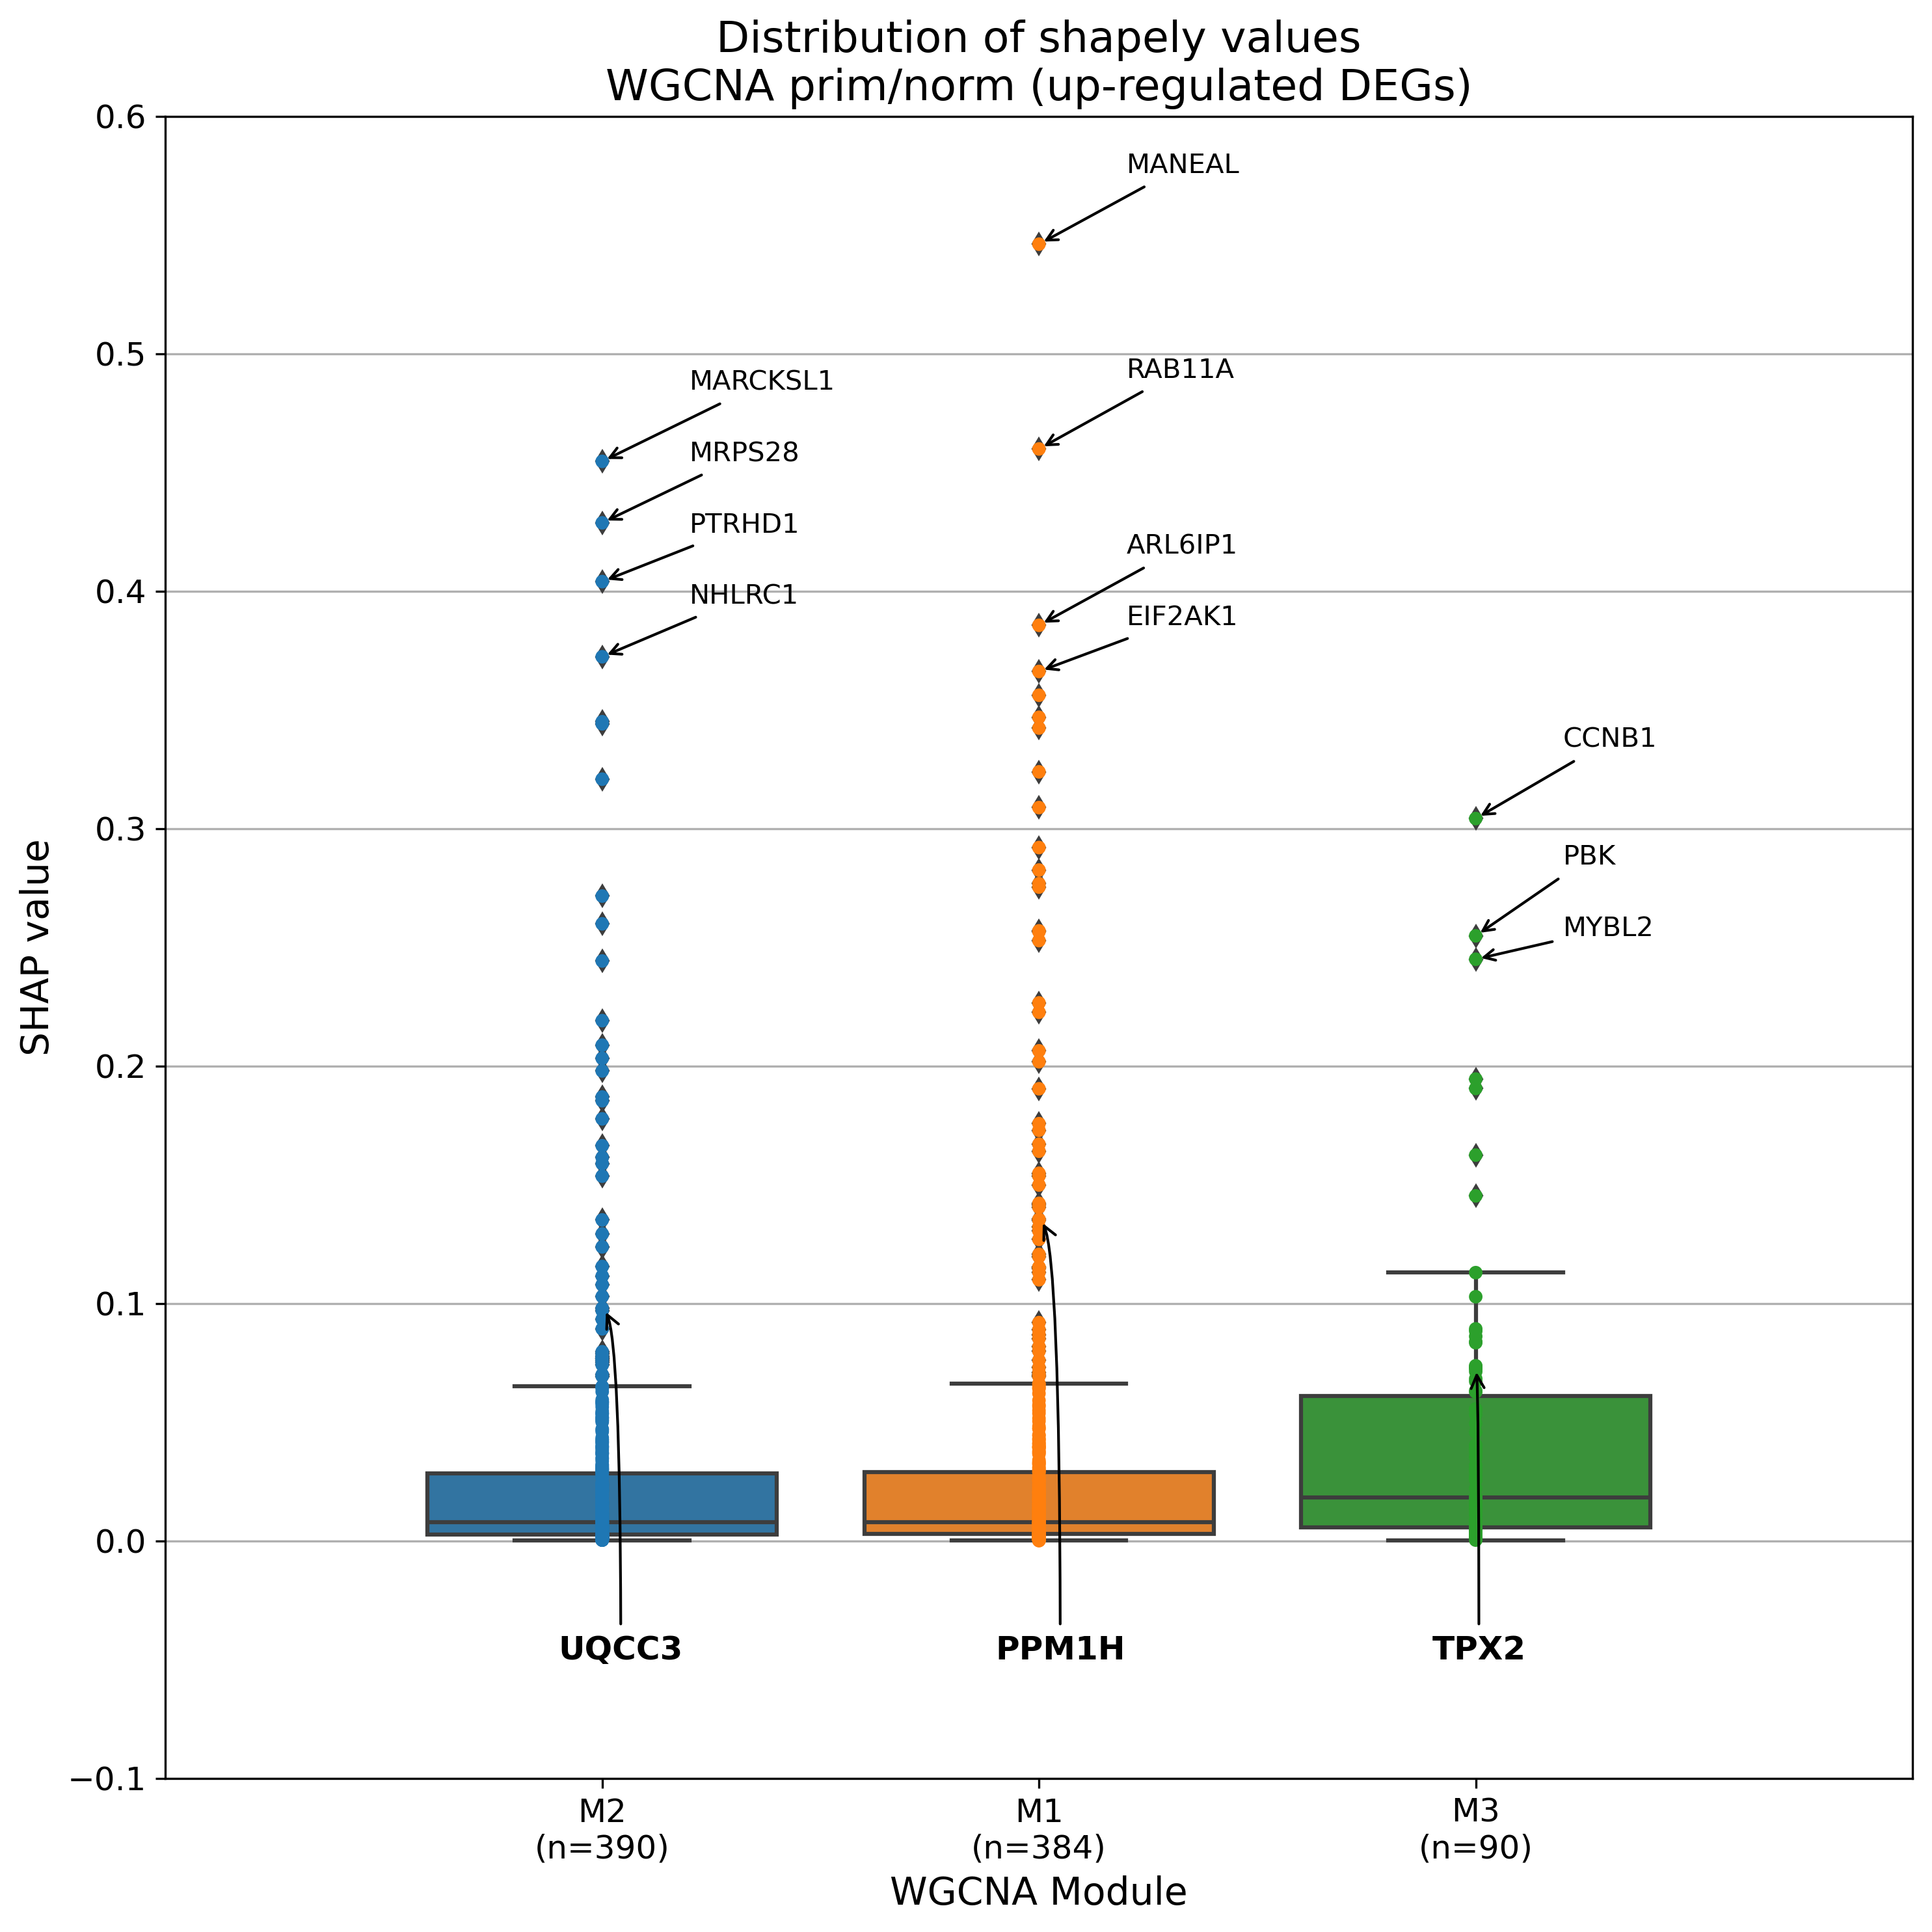

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

ax = sns.stripplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    jitter=False,
    ax=ax,
)

ax = sns.boxplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    ax=ax,
)

# annotate top genes by SHAP value
for mod_id, (mod, mod_df) in enumerate(graph_nodes_df.groupby("module")):
    mod_df.sort_values("shap_value", ascending=False, inplace=True)
    text_y = 99
    for i in range(min(5, len(mod_df))):
        gene_meta = mod_df.iloc[i]
        if gene_meta["shap_value"] > 0.2:
            text_y_new = gene_meta["shap_value"] + 0.03
            text_y_new = (
                (text_y := text_y_new)
                if text_y - text_y_new > 0.03
                else (text_y := text_y - 0.03)
            )
            plt.annotate(
                gene_meta.name,
                xy=(mod_id, gene_meta["shap_value"]),
                xytext=(mod_id + 0.2, text_y_new),
                arrowprops=dict(facecolor="black", arrowstyle="->"),
                fontsize=10,
            )

# annotate module hub genes
for mod_id, (mod, hub_gene) in enumerate(mod_hub_genes.items()):
    plt.annotate(
        hub_gene,
        xy=(mod_id, graph_nodes_df.loc[hub_gene, "shap_value"]),
        xytext=(mod_id - 0.1, -0.05),
        ha="left",
        arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="Angle3"),
        fontweight="bold",
        fontsize=12,
    )

plt.ylabel("SHAP value", fontsize=14)
plt.xlabel("WGCNA Module", fontsize=14)
plt.xticks(
    np.arange(0, graph_nodes_df["module"].nunique(), 1),
    [f"{m}\n(n={c})" for m, c in graph_nodes_df["module"].value_counts().items()],
    fontsize=12,
)
plt.yticks(fontsize=12)
plt.title(
    "Distribution of shapely values\nWGCNA prim/norm (up-regulated DEGs)", fontsize=16
)
ax.set_axisbelow(True)
plt.grid(axis="y", zorder=-10)
plt.ylim((-0.1, 0.6))
plt.xlim((-1, graph_nodes_df["module"].nunique()))
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig(FIGURES_PATH.joinpath("6_prim_norm_wgcna.pdf"))
plt.savefig(FIGURES_PATH.joinpath("6_prim_norm_wgcna.svg"))

### B: hspc/prim

In [9]:
hub_genes_df = pd.read_csv(
    ROOT.joinpath("wgcna")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("results")
    .joinpath("bicor_signed_hub_genes.csv"),
    index_col=0,
)
mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
del mod_hub_genes["M0"]
mod_hub_genes

{'M1': 'MPO',
 'M2': 'TPX2',
 'M3': 'C5AR2',
 'M4': 'DNAH17',
 'M5': 'CRYBG2',
 'M6': 'LHX4',
 'M7': 'SPATC1'}

In [10]:
network_file = (
    ROOT.joinpath("rich_network")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("random_forest")
    .joinpath(
        "sample_type_hspc+mcrpc+norm+prim__"
        "hspc_vs_prim_padj_0_05_up_1_0_corr_th_0_1_full_wgcna_ml_net.graphml"
    )
)
graph = nx.read_graphml(network_file)

In [11]:
graph_nodes_df = pd.DataFrame(dict(graph.nodes)).transpose().sort_values("module")
graph_nodes_df["shap_value"] = graph_nodes_df["shap_value"].astype(float)
graph_nodes_df["log2FoldChange"] = graph_nodes_df["log2FoldChange"].astype(float)
graph_nodes_df.head()

,shap_value,ENTREZID,module,ClusterCoef,Connectivity,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GENENAME,GENETYPE
MPO,0.001725,4353,M1,0.366518,509.22486,167.070113,3.780948,0.302169,12.512691,0.0,0.0,myeloperoxidase,protein-coding
PAX3,0.001132,5077,M1,0.361724,436.640067,15.105759,1.954059,0.355692,5.493689,0.0,0.0,paired box 3,protein-coding
ADH1B,0.001187,125,M1,0.358484,383.971921,714.277092,1.348882,0.222844,6.05303,0.0,0.0,"alcohol dehydrogenase 1B (class I), beta polyp...",protein-coding
ASGR1,0.002094,432,M1,0.361685,439.356924,79.425248,1.131859,0.190652,5.93678,0.0,0.0,asialoglycoprotein receptor 1,protein-coding
NRXN1,0.001908,9378,M1,0.358548,382.252488,361.787453,1.116044,0.234982,4.749493,0.000002,0.000009,neurexin 1,protein-coding


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


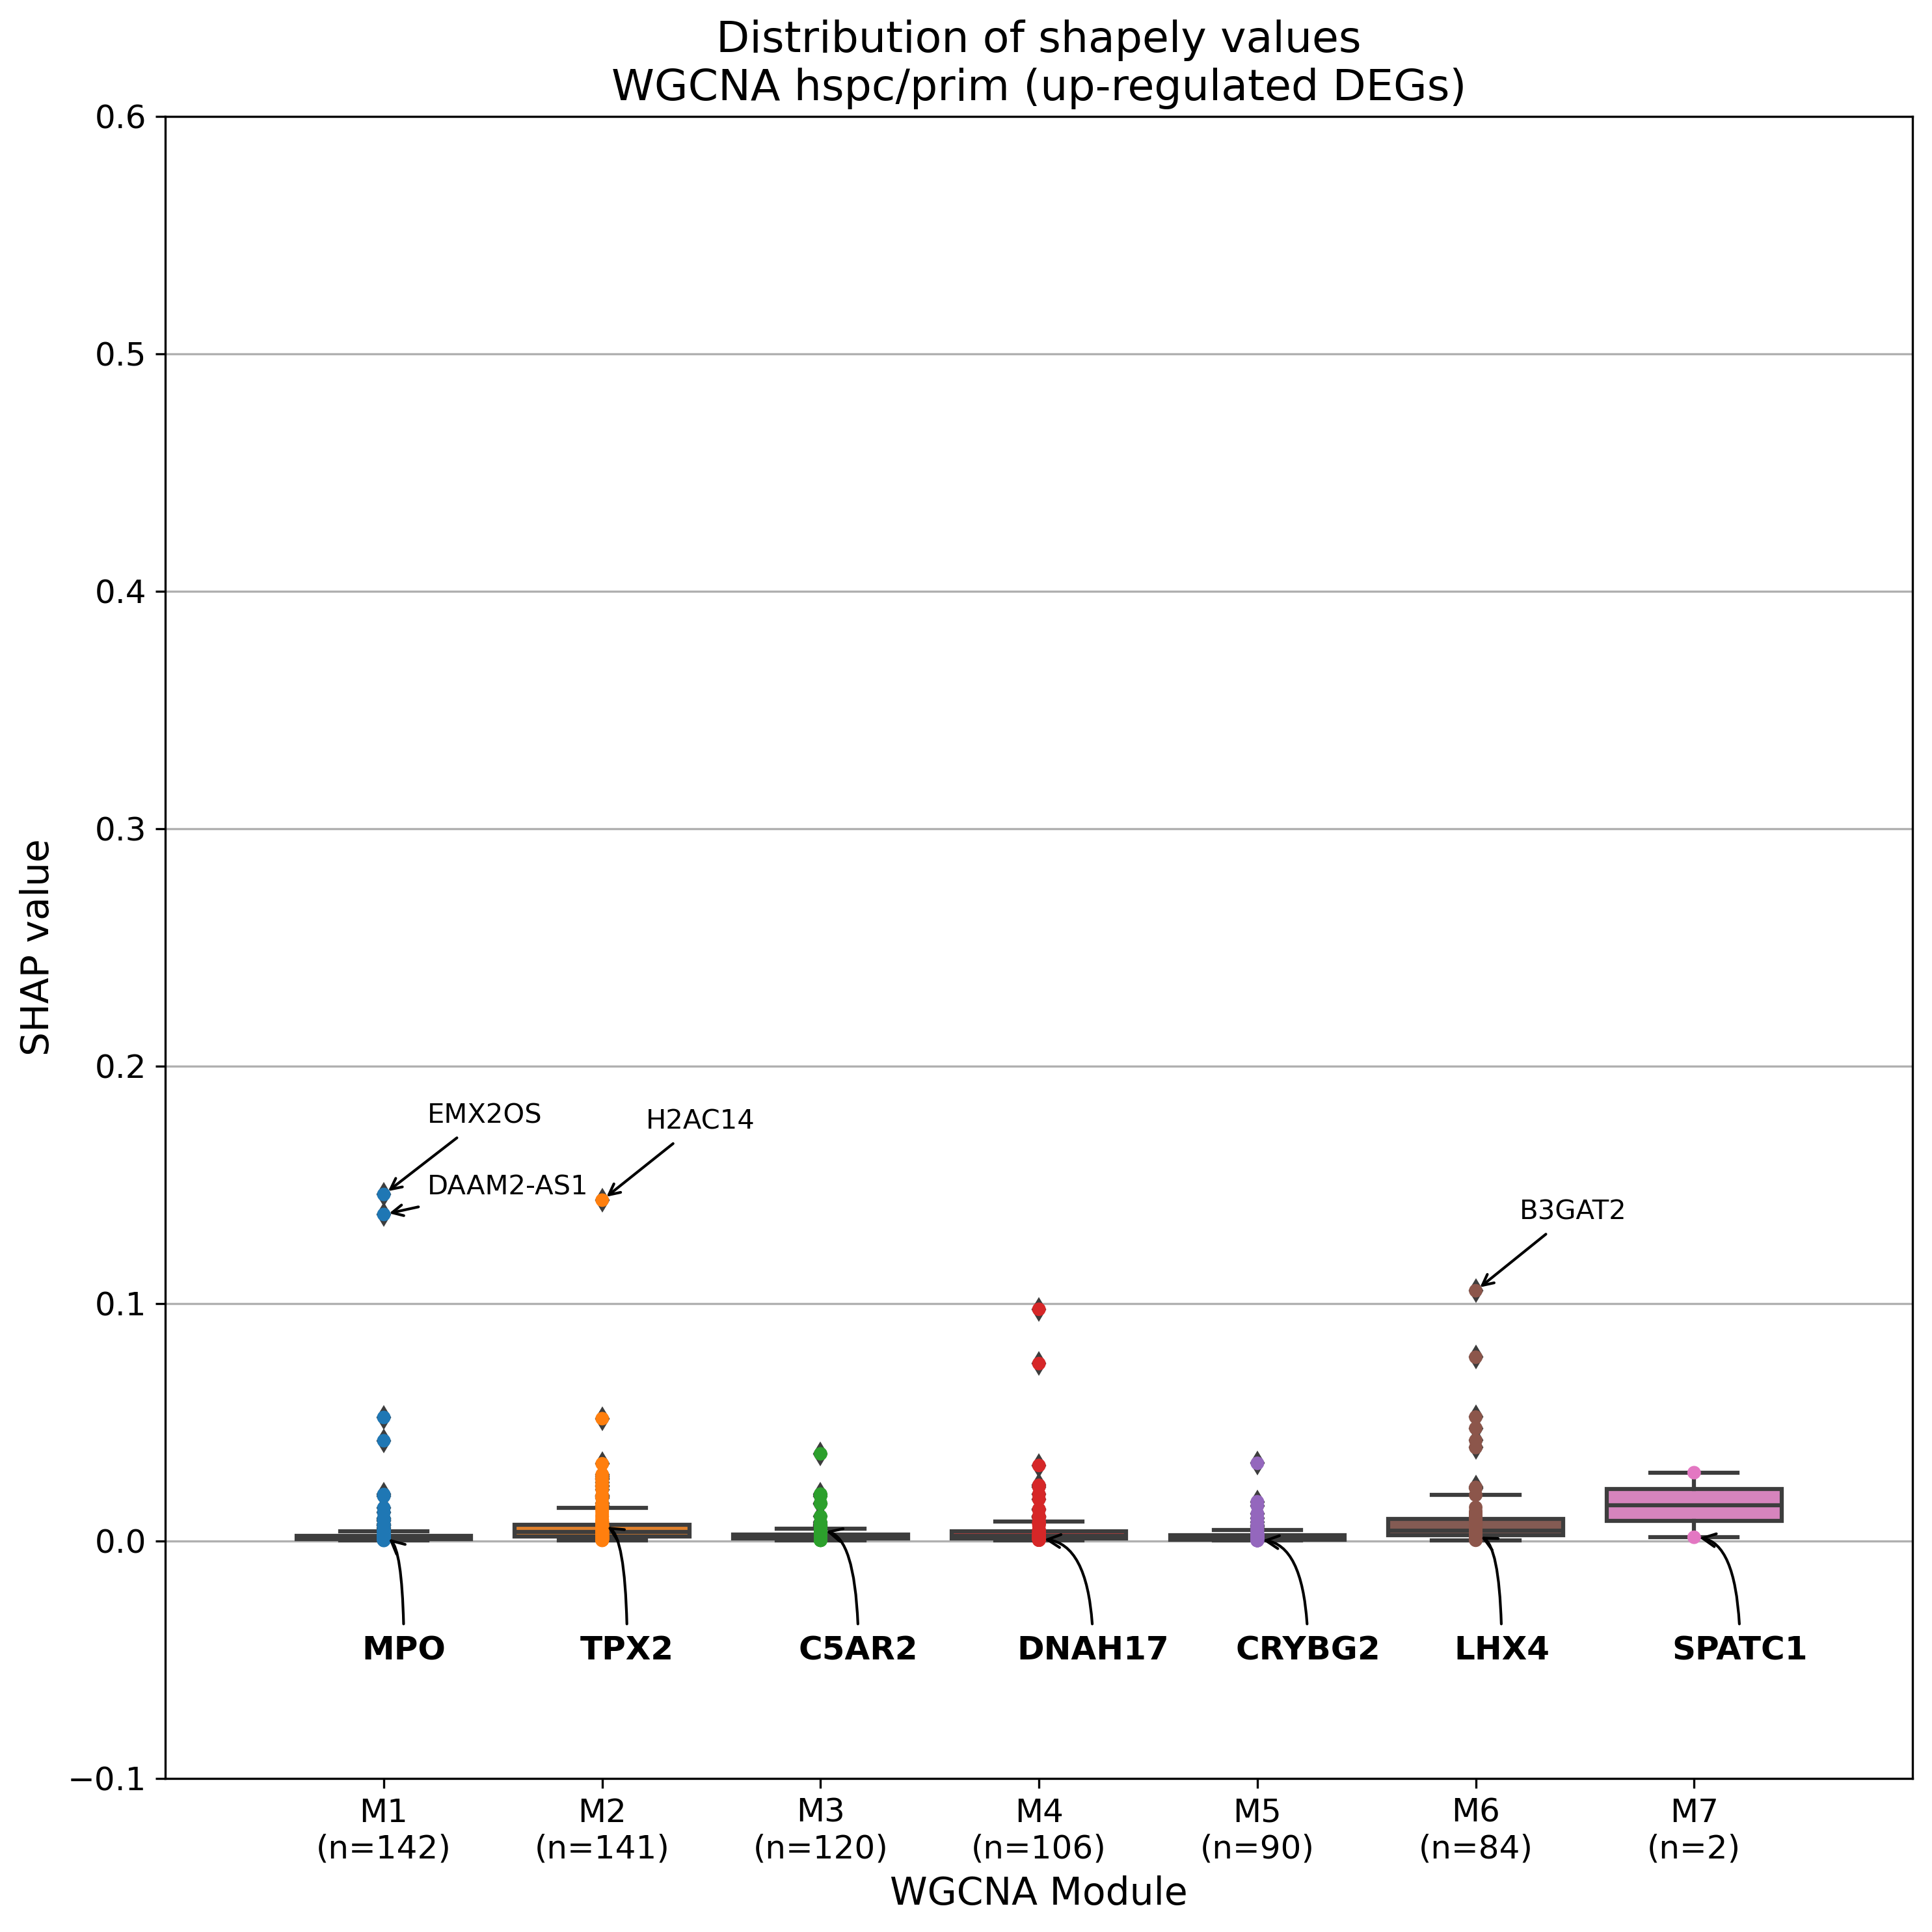

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

ax = sns.stripplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    jitter=False,
    ax=ax,
)

ax = sns.boxplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    ax=ax,
)

# annotate top genes by SHAP value
for mod_id, (mod, mod_df) in enumerate(graph_nodes_df.groupby("module")):
    mod_df.sort_values("shap_value", ascending=False, inplace=True)
    text_y = 99
    for i in range(min(5, len(mod_df))):
        gene_meta = mod_df.iloc[i]
        if gene_meta["shap_value"] > 0.1:
            text_y_new = gene_meta["shap_value"] + 0.03
            text_y_new = (
                (text_y := text_y_new)
                if text_y - text_y_new > 0.03
                else (text_y := text_y - 0.03)
            )
            plt.annotate(
                gene_meta.name,
                xy=(mod_id, gene_meta["shap_value"]),
                xytext=(mod_id + 0.2, text_y_new),
                arrowprops=dict(facecolor="black", arrowstyle="->"),
                fontsize=10,
            )

# annotate module hub genes
for mod_id, (mod, hub_gene) in enumerate(mod_hub_genes.items()):
    plt.annotate(
        hub_gene,
        xy=(mod_id, graph_nodes_df.loc[hub_gene, "shap_value"]),
        xytext=(mod_id - 0.1, -0.05),
        ha="left",
        arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="Angle3"),
        fontweight="bold",
        fontsize=12,
    )

plt.ylabel("SHAP value", fontsize=14)
plt.xlabel("WGCNA Module", fontsize=14)
plt.xticks(
    np.arange(0, graph_nodes_df["module"].nunique(), 1),
    [f"{m}\n(n={c})" for m, c in graph_nodes_df["module"].value_counts().items()],
    fontsize=12,
)
plt.yticks(fontsize=12)
plt.title(
    "Distribution of shapely values\nWGCNA hspc/prim (up-regulated DEGs)", fontsize=16
)
plt.ylim((-0.1, 0.6))
plt.xlim((-1, graph_nodes_df["module"].nunique()))
ax.set_axisbelow(True)
plt.grid(axis="y", zorder=-10)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig(FIGURES_PATH.joinpath("6_hspc_prim_wgcna.pdf"))
plt.savefig(FIGURES_PATH.joinpath("6_hspc_prim_wgcna.svg"))

### C: mcrpc/hspc

In [13]:
hub_genes_df = pd.read_csv(
    ROOT.joinpath("wgcna")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("results")
    .joinpath("bicor_signed_hub_genes.csv"),
    index_col=0,
)
mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
del mod_hub_genes["M0"]
mod_hub_genes

{'M1': 'TPX2', 'M2': 'SP140', 'M3': 'EDDM13'}

In [14]:
network_file = (
    ROOT.joinpath("rich_network")
    .joinpath("sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0")
    .joinpath("standard")
    .joinpath("random_forest")
    .joinpath(
        "sample_type_hspc+mcrpc+norm+prim__"
        "mcrpc_vs_hspc_padj_0_05_up_1_0_corr_th_0_1_full_wgcna_ml_net.graphml"
    )
)
graph = nx.read_graphml(network_file)

In [15]:
graph_nodes_df = pd.DataFrame(dict(graph.nodes)).transpose().sort_values("module")
graph_nodes_df["shap_value"] = graph_nodes_df["shap_value"].astype(float)
graph_nodes_df["log2FoldChange"] = graph_nodes_df["log2FoldChange"].astype(float)
graph_nodes_df.head()

,shap_value,ENTREZID,module,ClusterCoef,Connectivity,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GENENAME,GENETYPE
PTTG1,0.002469,9232,M1,0.334544,598.564274,469.559464,1.055154,0.154675,6.821736,0.0,0.0,PTTG1 regulator of sister chromatid separation...,protein-coding
BUB1,0.003586,699,M1,0.334453,614.3581,385.412913,1.002863,0.136022,7.372806,0.0,0.0,BUB1 mitotic checkpoint serine/threonine kinase,protein-coding
FBXO43,0.001348,286151,M1,0.334526,661.635646,46.301049,1.074262,0.169432,6.340371,0.0,0.0,F-box protein 43,protein-coding
MYBL1,0.002248,4603,M1,0.334548,629.915611,218.014749,1.037158,0.119729,8.662578,0.0,0.0,MYB proto-oncogene like 1,protein-coding
KNL1,0.002366,57082,M1,0.334555,631.651014,291.313594,1.053714,0.138996,7.580876,0.0,0.0,kinetochore scaffold 1,protein-coding


/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/ssd/Perez/miniforge3/envs/bioinfo/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


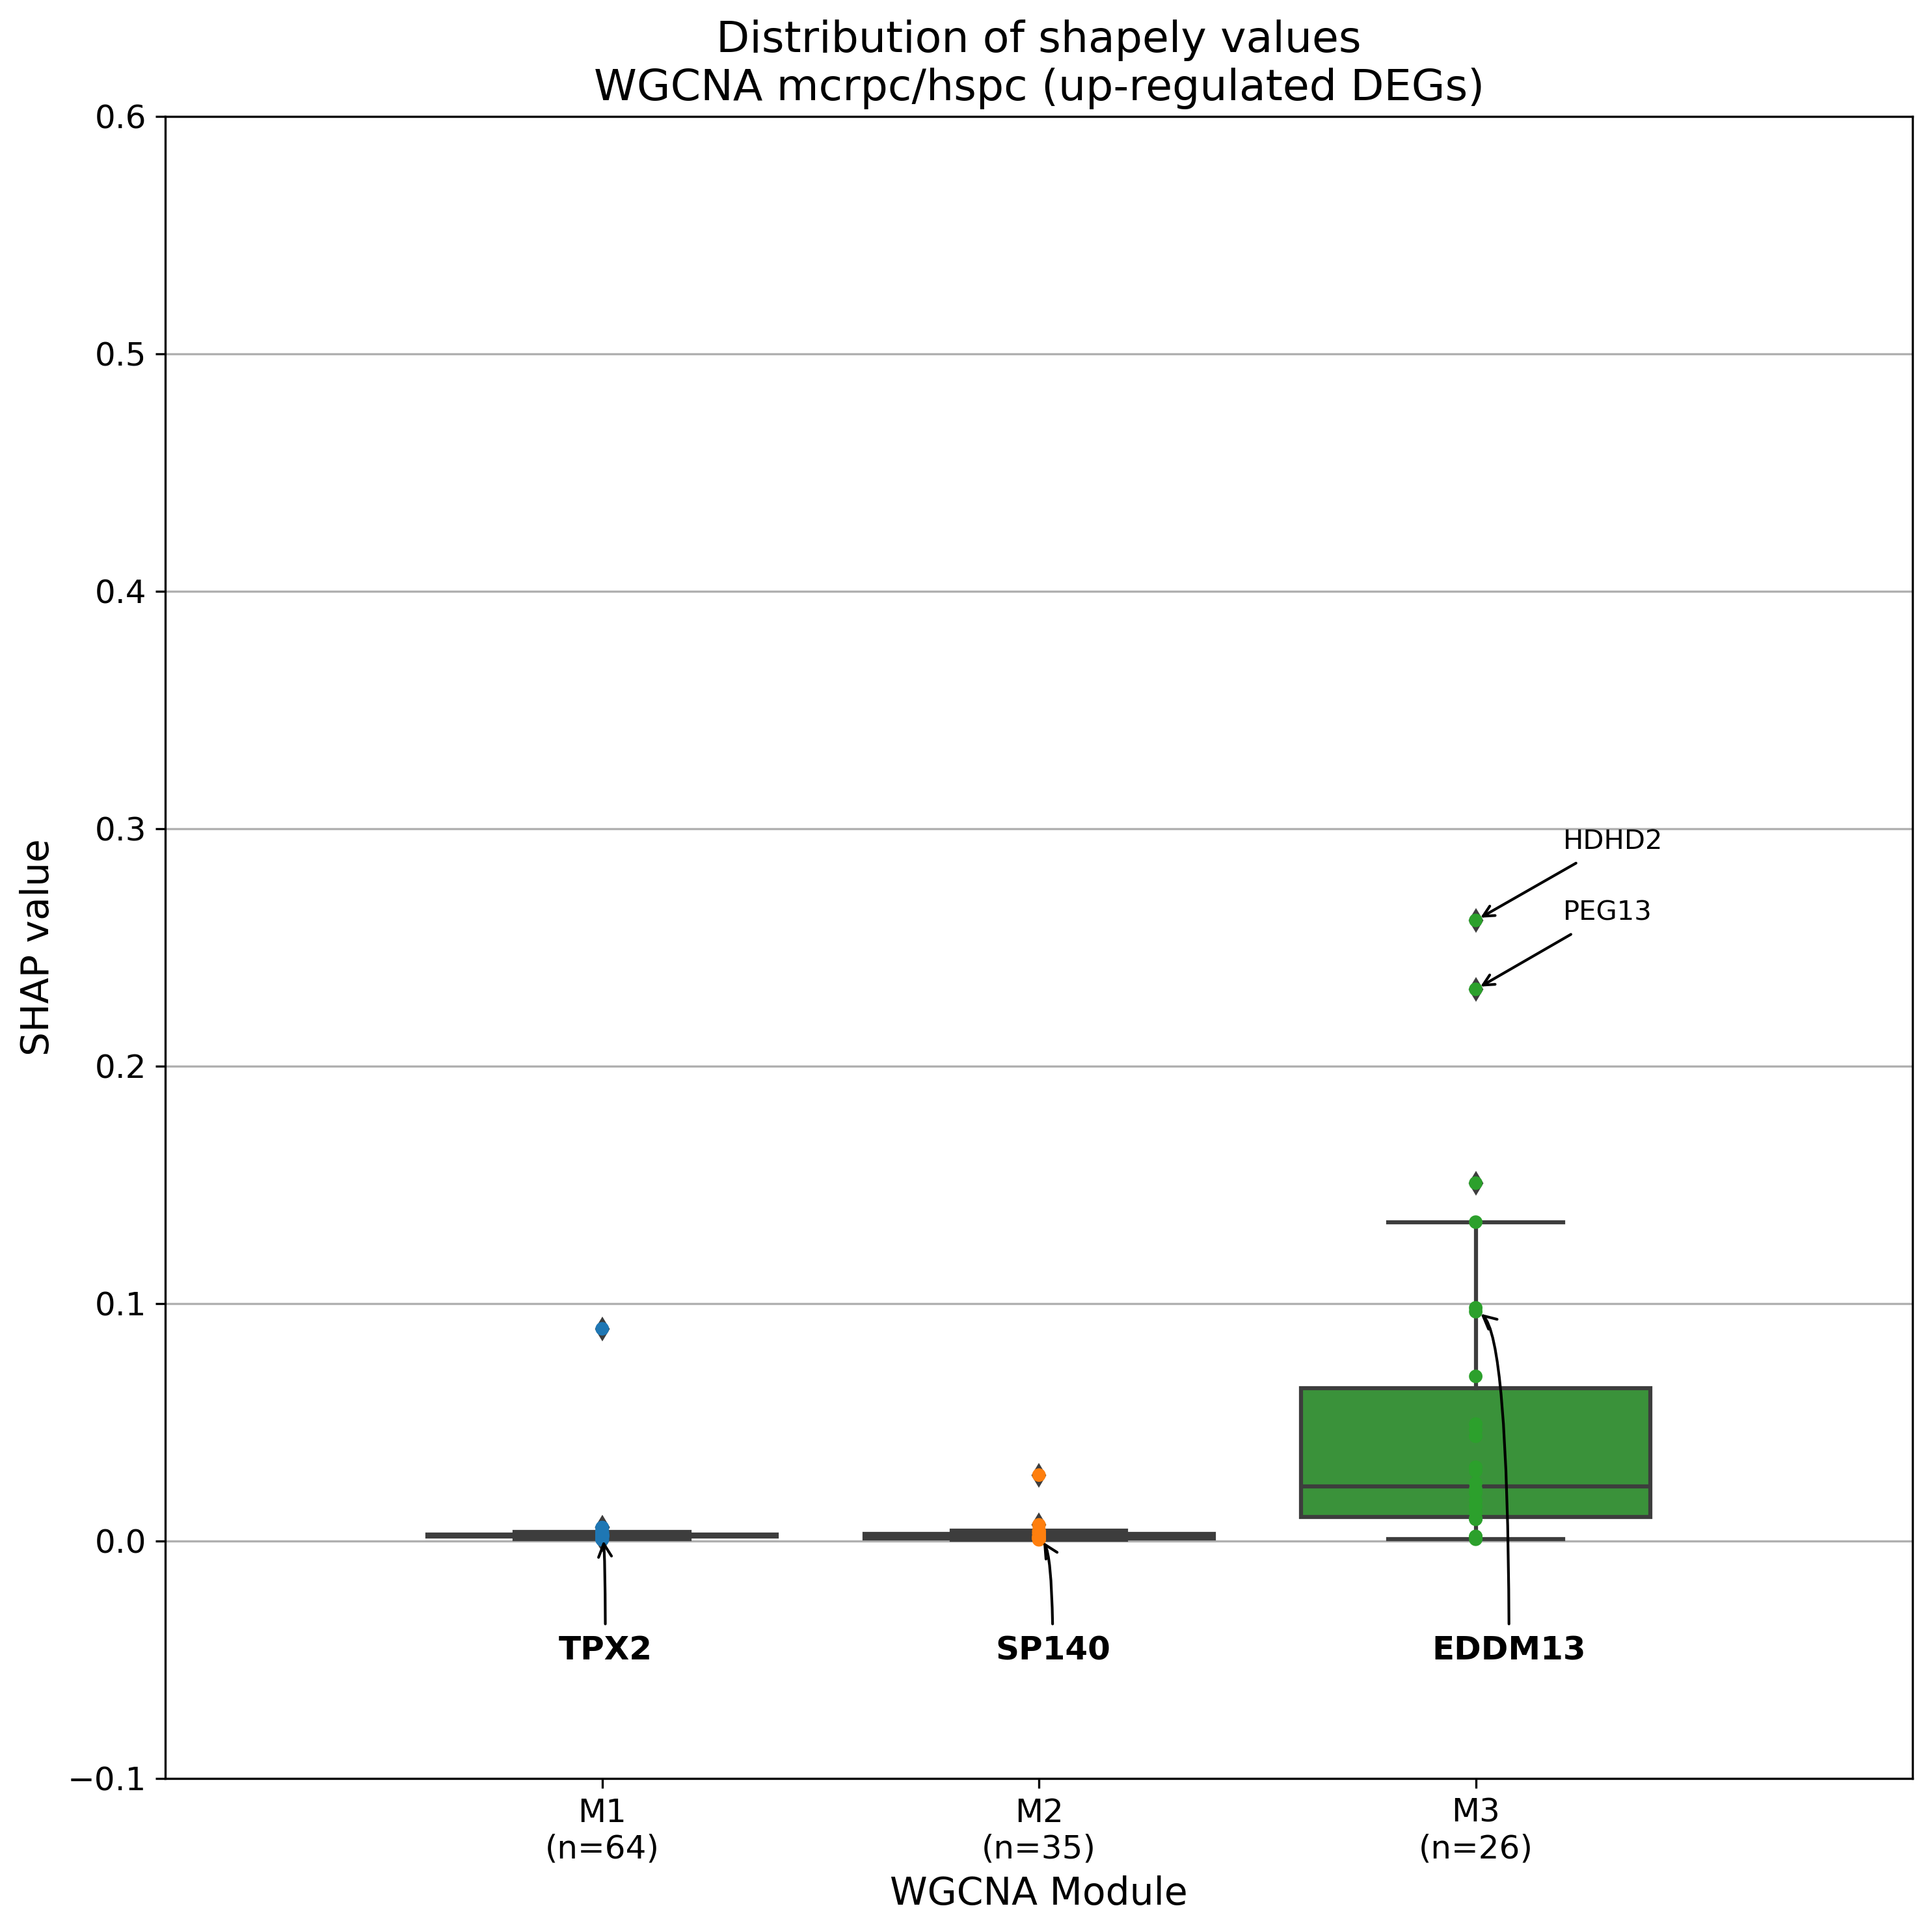

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

ax = sns.stripplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    jitter=False,
    ax=ax,
)

ax = sns.boxplot(
    data=graph_nodes_df,
    x="module",
    y="shap_value",
    hue="module",
    dodge=False,
    ax=ax,
)

# annotate top genes by SHAP value
for mod_id, (mod, mod_df) in enumerate(graph_nodes_df.groupby("module")):
    mod_df.sort_values("shap_value", ascending=False, inplace=True)
    text_y = 99
    for i in range(min(5, len(mod_df))):
        gene_meta = mod_df.iloc[i]
        if gene_meta["shap_value"] > 0.2:
            text_y_new = gene_meta["shap_value"] + 0.03
            text_y_new = (
                (text_y := text_y_new)
                if text_y - text_y_new > 0.03
                else (text_y := text_y - 0.03)
            )
            plt.annotate(
                gene_meta.name,
                xy=(mod_id, gene_meta["shap_value"]),
                xytext=(mod_id + 0.2, text_y_new),
                arrowprops=dict(facecolor="black", arrowstyle="->"),
                fontsize=10,
            )

# annotate module hub genes
for mod_id, (mod, hub_gene) in enumerate(mod_hub_genes.items()):
    plt.annotate(
        hub_gene,
        xy=(mod_id, graph_nodes_df.loc[hub_gene, "shap_value"]),
        xytext=(mod_id - 0.1, -0.05),
        ha="left",
        arrowprops=dict(facecolor="black", arrowstyle="->", connectionstyle="Angle3"),
        fontweight="bold",
        fontsize=12,
    )

plt.ylabel("SHAP value", fontsize=14)
plt.xlabel("WGCNA Module", fontsize=14)
plt.xticks(
    np.arange(0, graph_nodes_df["module"].nunique(), 1),
    [f"{m}\n(n={c})" for m, c in graph_nodes_df["module"].value_counts().items()],
    fontsize=12,
)
plt.yticks(fontsize=12)
plt.title(
    "Distribution of shapely values\nWGCNA mcrpc/hspc (up-regulated DEGs)", fontsize=16
)
plt.ylim((-0.1, 0.6))
plt.xlim((-1, graph_nodes_df["module"].nunique()))
ax.set_axisbelow(True)
plt.grid(axis="y", zorder=-10)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig(FIGURES_PATH.joinpath("6_mcrpc_hspc_wgcna.pdf"))
plt.savefig(FIGURES_PATH.joinpath("6_mcrpc_hspc_wgcna.svg"))